<a href="https://colab.research.google.com/github/ljtaylor99/AAI-530-Final-Project/blob/main/AAI530_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [39]:
import pandas as pd
import numpy as np
import glob
from datetime import datetime
import keras
import matplotlib.pyplot as plt
import os
# Setting seed for reproducibility
np.random.seed(1234)

PYTHONHASHSEED = 0
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Conv1D, BatchNormalization
from keras.layers.core import Activation
from keras.utils import pad_sequences

from sklearn.cluster import KMeans

In [2]:
paths = './*.csv'

In [3]:
# Loading all csv sheets and appending to empty DataFrame
all_data = pd.DataFrame()
for f in glob.glob(paths):
    df = pd.read_csv(f, engine='python')
    df['filename'] = f
    all_data = all_data.append(df, ignore_index=True)

In [4]:
# Checking for nulls
all_data.isnull().sum()

Date/Time    0
Lat          0
Lon          0
Base         0
filename     0
dtype: int64

In [5]:
# Looking at Base Num with greatest amount of rides
all_data.groupby('Base').count()

,Date/Time,Lat,Lon,filename
Base,,,,
B02512,104810,104810,104810,104810
B02598,686787,686787,686787,686787
B02617,415195,415195,415195,415195
B02682,645617,645617,645617,645617
B02764,28386,28386,28386,28386


In [6]:
# Making sure Date/Time is in DateTime format
all_data['Date/Time'] = pd.to_datetime(all_data['Date/Time'])

all_data['MonthNum'] = all_data['Date/Time'].dt.month
all_data['DayNum'] = all_data['Date/Time'].dt.day
all_data['Time'] = all_data['Date/Time'].dt.time

In [7]:
all_data.groupby(['MonthNum', 'Base']).count()

Date/Time     Lat     Lon  filename  DayNum    Time
MonthNum Base                                                       
4        B02512      35536   35536   35536     35536   35536   35536
         B02598     183263  183263  183263    183263  183263  183263
         B02617     108001  108001  108001    108001  108001  108001
         B02682     227808  227808  227808    227808  227808  227808
         B02764       9908    9908    9908      9908    9908    9908
5        B02512      36765   36765   36765     36765   36765   36765
         B02598     260549  260549  260549    260549  260549  260549
         B02617     122734  122734  122734    122734  122734  122734
         B02682     222883  222883  222883    222883  222883  222883
         B02764       9504    9504    9504      9504    9504    9504
6        B02512      32509   32509   32509     32509   32509   32509
         B02598     242975  242975  242975    242975  242975  242975
         B02617     184460  184460  184460    184460  184460  184460
         B02682     194926  194926  194926    194926  194926  194926
         B02764       8974    8974    8974      8974    8974    8974

In [8]:
all_data.groupby(['DayNum','Base']).count()

Date/Time    Lat    Lon  filename  MonthNum   Time
DayNum Base                                                      
1      B02512       3204   3204   3204      3204      3204   3204
       B02598      18809  18809  18809     18809     18809  18809
       B02617      11202  11202  11202     11202     11202  11202
       B02682      19786  19786  19786     19786     19786  19786
       B02764        887    887    887       887       887    887
...                  ...    ...    ...       ...       ...    ...
31     B02512       1045   1045   1045      1045      1045   1045
       B02598       8624   8624   8624      8624      8624   8624
       B02617       4692   4692   4692      4692      4692   4692
       B02682       6594   6594   6594      6594      6594   6594
       B02764        306    306    306       306       306    306

[155 rows x 6 columns]

In [ ]:
# Function to get day of the week
def get_day_name(date):
    date = pd.Timestamp(date)
    return date.day_name()

In [ ]:
# Using apply lambda function since casting to Timestamp is temporary
# i.e. modifying in place rather than a full cast
all_data['DayOfWeek'] = all_data['Date/Time'].apply(lambda x: get_day_name(x))

In [ ]:
all_data.groupby(['DayOfWeek']).count()

In [9]:
# Subsetting data with greatest number of rides
all_data = all_data[all_data['Base'] == 'B02598']
# Dropping Multiple Date/Time as it does not make sense for multiple lat/lon
# For each time (Multiple riders within the minute) -> Need second breakdown if
# This is possible
all_data = all_data.drop_duplicates(['Date/Time'], keep='first')

# Setting Date/Time to index -> ready to resample and forward fille
all_data = all_data.set_index(all_data['Date/Time']).drop(columns=['Date/Time'])
# Filling in missing data -> Last pick up point will stay constant until new
# Pick up point created
all_data = all_data.resample('1T').ffill()
# Subsetting for 12 hour window
all_data = all_data.between_time('08:00:00', '20:00:00')
all_data = all_data.reset_index()

all_data.head()

,Date/Time,Lat,Lon,Base,filename,MonthNum,DayNum,Time
0,2014-04-01 08:00:00,40.7747,-73.9901,B02598,./uber-raw-data-apr14.csv,4,1,08:00:00
1,2014-04-01 08:01:00,40.7356,-74.0028,B02598,./uber-raw-data-apr14.csv,4,1,08:01:00
2,2014-04-01 08:02:00,40.7156,-73.9536,B02598,./uber-raw-data-apr14.csv,4,1,08:02:00
3,2014-04-01 08:03:00,40.7595,-73.9919,B02598,./uber-raw-data-apr14.csv,4,1,08:03:00
4,2014-04-01 08:04:00,40.7319,-73.9937,B02598,./uber-raw-data-apr14.csv,4,1,08:04:00


In [13]:
# Subsetting to day with most rides
fri_data = all_data[all_data['DayOfWeek']=='Friday'].reset_index(drop=True)

In [14]:
# Creating train and test split points
df_size = round(len(fri_data)/100)
start = np.random.choice(range(0,len(fri_data)-df_size))
df_small = fri_data.iloc[start:start+df_size].reset_index()


split_point = round(len(df_small)*0.8)
train_df = df_small.iloc[:split_point]
val_df = df_small.iloc[split_point:]

train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)

In [15]:
ph = 1
seq_length = 15

In [16]:
lon_arrays = []
lon_labs = []

# Creating train data sequences
for start in range(0,len(train_df)-seq_length-ph):
    lon_arrays.append(train_df[['Lon']].iloc[start:start+seq_length].to_numpy())
    lon_labs.append(train_df['Lon'].iloc[start+seq_length+ph])

# Converting to float
lon_arrays = np.array(lon_arrays, dtype = object).astype(np.float32)
lon_labs = np.array(lon_labs, dtype = object).astype(np.float32)

# Assertion to make sure data is in correct shape
assert(lon_arrays.shape == (len(train_df)-seq_length-ph,seq_length,1))
assert(lon_labs.shape == (len(train_df)-seq_length-ph,))

In [17]:
lat_arrays = []
lat_labs = []

# Creating train data sequences
for start in range(0,len(train_df)-seq_length-ph):
    lat_arrays.append(train_df[['Lat']].iloc[start:start+seq_length].to_numpy())
    lat_labs.append(train_df['Lat'].iloc[start+seq_length+ph])

# Converting to float
lat_arrays = np.array(lat_arrays, dtype = object).astype(np.float32)
lat_labs = np.array(lat_labs, dtype = object).astype(np.float32)

# Assertion to make sure data is in correct shape
assert(lat_arrays.shape == (len(train_df)-seq_length-ph,seq_length,1))
assert(lat_labs.shape == (len(train_df)-seq_length-ph,))

In [18]:
# Files names
lat_model_path = 'LSTM_model_latitude.h5'
lon_model_path = 'LSTM_model_longitude.h5'

In [19]:
nb_features = 1
nb_out = 1 
optimizer = keras.optimizers.Adam(learning_rate = 0.01)

In [20]:
# Starting to add layers to model
lat_model = Sequential()
lat_model.add(Conv1D(32, input_shape=(seq_length, nb_features), kernel_size=2, activation="relu"))
lat_model.add(BatchNormalization())
lat_model.add(Conv1D(64, input_shape=(seq_length, nb_features), kernel_size=2, activation="relu"))
lat_model.add(BatchNormalization())
lat_model.add(Conv1D(128, input_shape=(seq_length, nb_features), kernel_size=2, activation="relu"))
lat_model.add(BatchNormalization())
lat_model.add(Dropout(0.2))
lat_model.add(LSTM(input_shape=(seq_length, nb_features), units=50, return_sequences=True))
lat_model.add(Dropout(0.2))
lat_model.add(Dense(25, activation='linear'))
lat_model.add(LSTM(units=25,return_sequences=False))
lat_model.add(Dropout(0.2))
lat_model.add(Dense(units=nb_out))
lat_model.add(Activation("linear"))

lat_model.compile(loss='mean_squared_error', optimizer=optimizer,metrics=['mse'])
print(lat_model.summary())

# Training to 500 epochs but will terminuate early if validation loss is not great enough
lat_history = lat_model.fit(lat_arrays, lat_labs, epochs=500, batch_size=8, validation_split=0.05, verbose=2, callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min'), keras.callbacks.ModelCheckpoint(lat_model_path,monitor='val_loss', save_best_only=True, mode='min', verbose=0)])


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 14, 32)            96        
                                                                 
 batch_normalization (BatchN  (None, 14, 32)           128       
 ormalization)                                                   
                                                                 
 conv1d_1 (Conv1D)           (None, 13, 64)            4160      
                                                                 
 batch_normalization_1 (Batc  (None, 13, 64)           256       
 hNormalization)                                                 
                                                                 
 conv1d_2 (Conv1D)           (None, 12, 128)           16512     
                                                                 
 batch_normalization_2 (Batc  (None, 12, 128)          5

In [21]:
# Starting to add layers to model
lon_model = Sequential()
lon_model.add(Conv1D(32, input_shape=(seq_length, nb_features), kernel_size=2, activation="relu"))
lon_model.add(BatchNormalization())
lon_model.add(Conv1D(64, input_shape=(seq_length, nb_features), kernel_size=2, activation="relu"))
lon_model.add(BatchNormalization())
lon_model.add(Conv1D(128, input_shape=(seq_length, nb_features), kernel_size=2, activation="relu"))
lon_model.add(BatchNormalization())
lon_model.add(Dropout(0.2))
lon_model.add(LSTM(input_shape=(seq_length, nb_features), units=50, return_sequences=True))
lon_model.add(Dropout(0.2))
lon_model.add(Dense(25, activation='linear'))
lon_model.add(LSTM(units=25,return_sequences=False))
lon_model.add(Dropout(0.2))
lon_model.add(Dense(units=nb_out))
lon_model.add(Activation("linear"))

lon_model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mse'])
print(lon_model.summary())

lon_history = lon_model.fit(lon_arrays, lon_labs, epochs=500, batch_size=8, validation_split=0.05, verbose=2, callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min'), keras.callbacks.ModelCheckpoint(lon_model_path,monitor='val_loss', save_best_only=True, mode='min', verbose=0)])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3 (Conv1D)           (None, 14, 32)            96        
                                                                 
 batch_normalization_3 (Batc  (None, 14, 32)           128       
 hNormalization)                                                 
                                                                 
 conv1d_4 (Conv1D)           (None, 13, 64)            4160      
                                                                 
 batch_normalization_4 (Batc  (None, 13, 64)           256       
 hNormalization)                                                 
                                                                 
 conv1d_5 (Conv1D)           (None, 12, 128)           16512     
                                                                 
 batch_normalization_5 (Batc  (None, 12, 128)         

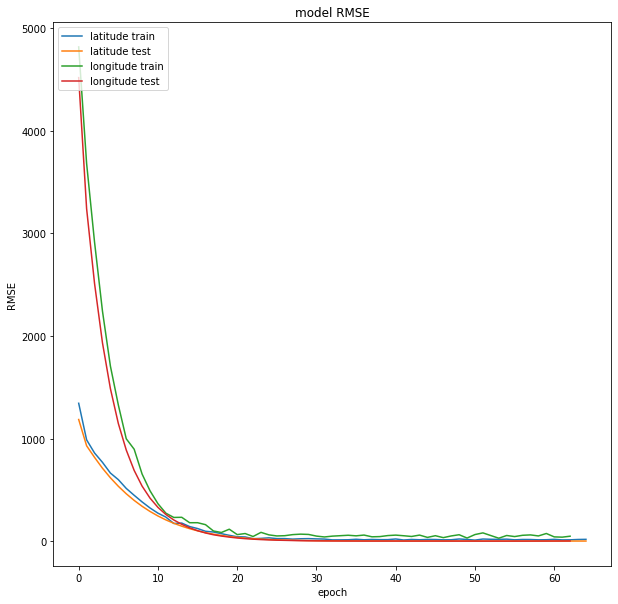

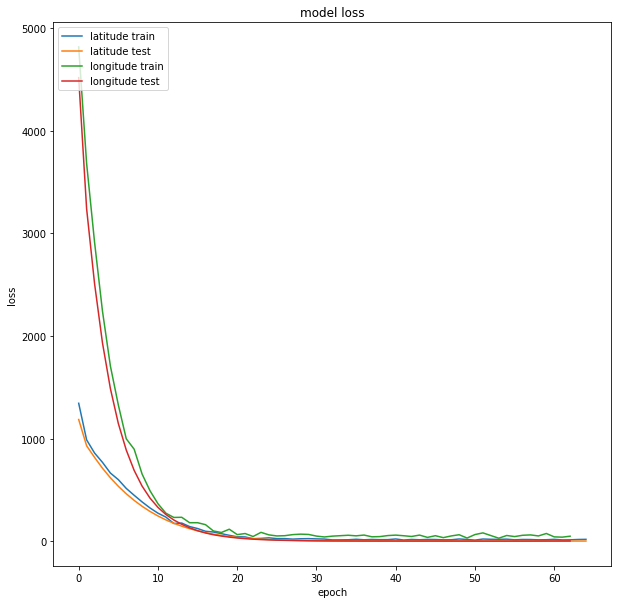

In [22]:
# Creating plot of RMSE
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(lat_history.history['mse'])
plt.plot(lat_history.history['val_mse'])
plt.plot(lon_history.history['mse'])
plt.plot(lon_history.history['val_mse'])
plt.title('model RMSE')
plt.ylabel('RMSE')
plt.xlabel('epoch')
plt.legend(['latitude train', 'latitude test', 'longitude train', 'longitude test'], loc='upper left')
plt.show()
fig_acc.savefig("LSTM_rmse.png")
# Creating plot of loss
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(lat_history.history['loss'])
plt.plot(lat_history.history['val_loss'])
plt.plot(lon_history.history['loss'])
plt.plot(lon_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['latitude train', 'latitude test', 'longitude train', 'longitude test'], loc='upper left')
plt.show()
fig_acc.savefig("LSTM_loss.png")

In [23]:
lat_val_arrays = []
lat_val_labs = []

# Creating sequences for validation data
for end in range(2, len(val_df)-ph):
  if end < seq_length:
    lat_val_arrays.append(val_df[['Lat']][0:end].to_numpy())
    lat_val_labs.append(val_df['Lat'][end+ph])
  else:
    lat_val_arrays.append(val_df[['Lat']][end-seq_length:end].to_numpy())
    lat_val_labs.append(val_df['Lat'][end+ph])

# use the pad_sequences function on your input sequences
lat_val_arrays = pad_sequences(lat_val_arrays, maxlen = seq_length, dtype = np.float32)
# convert to numpy arrays and floats
lat_val_labs = np.array(lat_val_labs, dtype = object).astype(np.float32)

1/1 - 0s - loss: 1.5854 - mse: 1.5854 - 110ms/epoch - 110ms/step

MSE: 1.5854074954986572
1/1 [==============================] - 0s 105ms/step


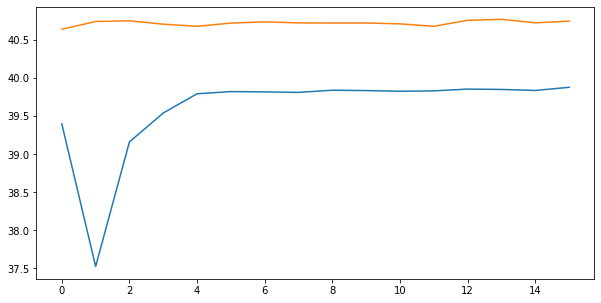

In [27]:
# Evaluating model on validation data
lat_scores_test = lat_model.evaluate(lat_val_arrays, lat_val_labs, verbose=2)
print('\nMSE: {}'.format(lat_scores_test[1]))
# Predicting data
lat_y_pred_test = lat_model.predict(lat_val_arrays)
lat_y_true_test = lat_val_labs
lat_test_set = pd.DataFrame(lat_y_pred_test)
lat_test_set.to_csv('lat_submit_test.csv', index = None)
# Plot the predicted data vs. the actual data
# we will limit our plot to the first 200 predictions for better visualization
lat_fig_verify = plt.figure(figsize=(10, 5))
plt.plot(lat_y_pred_test, label = 'Latitude Predicted Value')
plt.plot(lat_y_true_test, label = 'Latitude Actual Value')

In [25]:
lon_val_arrays = []
lon_val_labs = []

# Creating test sequences
for end in range(2, len(val_df)-ph):
  if end < seq_length:
    lon_val_arrays.append(val_df[['Lon']][0:end].to_numpy())
    lon_val_labs.append(val_df['Lon'][end+ph])
  else:
    lon_val_arrays.append(val_df[['Lon']][end-seq_length:end].to_numpy())
    lon_val_labs.append(val_df['Lon'][end+ph])

# use the pad_sequences function on your input sequences
lon_val_arrays = pad_sequences(lon_val_arrays, maxlen = seq_length, dtype = np.float32)
# convert to numpy arrays and float
lon_val_labs = np.array(lon_val_labs, dtype = object).astype(np.float32)

1/1 - 0s - loss: 1.4902 - mse: 1.4902 - 26ms/epoch - 26ms/step

MSE: 1.4902198314666748
1/1 [==============================] - 1s 924ms/step


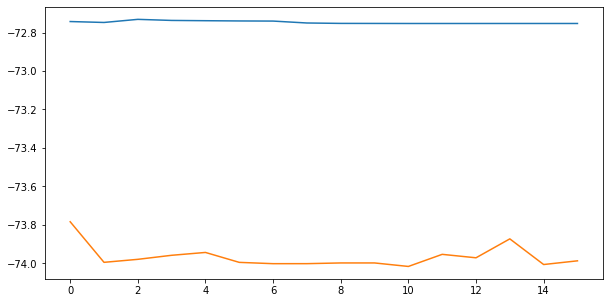

In [26]:
# Evaluating model on validation data
lon_scores_test = lon_model.evaluate(lon_val_arrays, lon_val_labs, verbose=2)
print('\nMSE: {}'.format(lon_scores_test[1]))
# Predicting arrays
lon_y_pred_test = lon_model.predict(lon_val_arrays)
lon_y_true_test = lon_val_labs
lon_test_set = pd.DataFrame(lon_y_pred_test)
lon_test_set.to_csv('lon_submit_test.csv', index = None)
# Plot the predicted data vs. the actual data
lon_fig_verify = plt.figure(figsize=(10, 5))
plt.plot(lon_y_pred_test, label = 'Longtitude Predicted Value')
plt.plot(lon_y_true_test, label = 'Longtitude Actual Value')

In [30]:
# Rechecking fri_data shape
fri_data.shape

(9373, 9)

In [33]:
# Turning fri_data lat and lon values into coordinates for k-means clustering
fri_data_coord = list(zip(fri_data['Lat'], fri_data['Lon']))
# Sanity check
len(fri_data_coord)

9373

In [34]:
kmeans = KMeans(init="random", n_clusters=3, n_init=10, max_iter=100, random_state=123)
kmeans.fit(fri_data_coord)
kmeans.cluster_centers_


array([[ 40.72965549, -73.81454346],
       [ 40.71993475, -73.9962429 ],
       [ 40.76477119, -73.97294363]])

In [36]:
kwargs = {
  "init": "random",
  "n_init": 10,
  "max_iter": 300,
  "random_state": 42,
}

sse = []
for k in range(1, 11):
     kmeans = KMeans(n_clusters=k, **kwargs)
     kmeans.fit(fri_data_coord)
     sse.append(kmeans.inertia_)

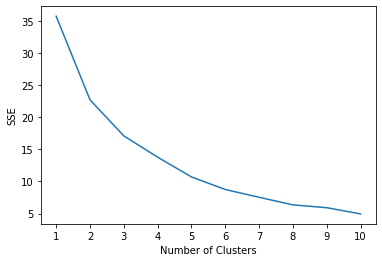

In [37]:
plt.plot(range(1, 11), sse)
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

In [44]:
# Looking for the elbow, looking at 3 clusters
fin_kmeans = KMeans(init="random", n_clusters=3, n_init=10, max_iter=100, random_state=123)
fin_kmeans.fit(fri_data_coord)

# Adding cluster label to dataframe
fri_data['k_mean_cluster'] = fin_kmeans.labels_
fri_data.head()

,Date/Time,Lat,Lon,Base,filename,MonthNum,DayNum,Time,DayOfWeek,k_mean_cluster
0,2014-04-04 08:00:00,40.7016,-73.9881,B02598,./uber-raw-data-apr14.csv,4,4,08:00:00,Friday,1
1,2014-04-04 08:01:00,40.7250,-74.0084,B02598,./uber-raw-data-apr14.csv,4,4,08:01:00,Friday,1
2,2014-04-04 08:02:00,40.7608,-73.9992,B02598,./uber-raw-data-apr14.csv,4,4,08:02:00,Friday,2
3,2014-04-04 08:03:00,40.6872,-73.9756,B02598,./uber-raw-data-apr14.csv,4,4,08:03:00,Friday,1
4,2014-04-04 08:04:00,40.7257,-73.9903,B02598,./uber-raw-data-apr14.csv,4,4,08:04:00,Friday,1
